# Trading Strategy Based on High Returns and Low Correlation

This notebook implements a trading strategy using historical stock data from S&P 500 companies. The strategy aims to identify stocks with the highest returns and lowest correlation, and then assigns risk parity weights to this subset to balance risk and return. The performance of the strategy is evaluated using various metrics.

## Objective
The goal is to create a diversified portfolio that maximizes returns while minimizing risk by focusing on stocks that have high historical returns and low correlation with each other. This approach helps in reducing the impact of market volatility on the portfolio.

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import warnings
from tqdm import tqdm

# Suppress warnings to keep the output clean and focus on the strategy's results
warnings.filterwarnings("ignore")

# Limit the number of rows displayed to avoid overwhelming the output
pd.set_option('display.max_rows', 20)

## Data Collection

We start by collecting data on S&P 500 companies. The list of companies is obtained from Wikipedia, and historical stock prices are downloaded from Yahoo Finance. This data forms the basis of our analysis.

### Why Wikipedia and Yahoo Finance?
- **Wikipedia**: Provides a reliable and up-to-date list of S&P 500 companies.
- **Yahoo Finance**: Offers comprehensive historical stock price data that is freely accessible.

In [2]:
# Use Wikipedia as a reliable source to obtain the list of S&P 500 companies
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Extract the table of S&P 500 companies to get their ticker symbols
html = pd.read_html(url)
table = html[0]
tickers = table["Symbol"].to_list()

# Inform the user about the data download process
print("Downloading data from Yahoo finance")

# Download historical closing prices to analyze past performance
# Drop 'BRK.B' and 'BF.B' due to potential data issues or duplicates
prices = yf.download(tickers)["Close"].drop(['BRK.B', 'BF.B'], axis=1)

# Fill missing values by propagating the previous value forward
# This ensures that we have a complete dataset for analysis
prices = prices.ffill()

# Save the downloaded data to a CSV file for future reference and reproducibility
print("Writing data from Yahoo finance into CSV file")
prices.to_csv("prices.csv")

[*********************100%***********************]  503 of 503 completed

4 Failed downloads:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['BF.B', 'ETR', 'LEN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 1926-03-13 -> 2025-02-16)')


Writing data from Yahoo finance into CSV file


## Data Preparation

We prepare the data by calculating daily returns and setting up the training and test sets. This step is crucial for evaluating the strategy's performance over different time periods.

### Why Calculate Daily Returns?
- Daily returns provide a granular view of stock performance and are essential for calculating volatility and correlation.
- They help in identifying trends and patterns that can inform investment decisions.

In [3]:
# Read the data back from the CSV file to ensure it's correctly saved and can be reloaded
print("Reading data from CSV file into pandas dataframe")
prices = pd.read_csv(
    "prices.csv",
    index_col=0,
    parse_dates=True
    )

# Calculate daily returns to understand the percentage change in price from one day to the next
returns = prices.pct_change()

# Define the size of the training and test sets to balance learning and evaluation
train_size = 250
test_size = 25

# Calculate the number of iterations needed to cover the entire dataset
n = len(prices) - train_size - test_size

# Initialize a DataFrame to store strategy weights, which will be used to allocate investments
tiled_weights = pd.DataFrame(
    np.zeros(returns.shape),
    index=returns.index,
    columns=returns.columns
    )

Reading data from CSV file into pandas dataframe


## Strategy Computation

The core of the strategy involves selecting stocks with high returns and low correlation, and then assigning risk parity weights. This approach aims to balance risk and return by diversifying the portfolio.

### Why High Returns and Low Correlation?
- **High Returns**: Stocks with high historical returns are more likely to continue performing well.
- **Low Correlation**: Stocks with low correlation to each other help in reducing portfolio risk by diversifying.

### Why Risk Parity Weights?
- Risk parity weights allocate investments inversely proportional to volatility, ensuring that risk is evenly distributed across the portfolio.

In [4]:
# Inform the user about the strategy weight computation process
print("Computing strategy weights")

# Loop over the data to compute strategy weights for each test period
for i in tqdm(range(0, n, test_size)):
    train_start = i
    train_end = train_start + train_size
    test_start = train_end + 1
    test_end = test_start + test_size
    
    # Split the data into training and test sets to simulate real-world investment periods
    returns_train = returns.iloc[train_start:train_end]
    returns_test = returns.iloc[test_start:test_end]
    
    # Rank stocks based on their mean returns to identify high-performing stocks
    returns_rank = (-returns_train.mean().dropna()).sort_values().rank()
    
    # Rank stocks based on their correlation to identify those with low correlation to others
    corr_rank = returns_train.corr().abs().mean().dropna().sort_values().rank()
    
    # Combine the ranks to get a total rank that balances high returns and low correlation
    total_rank = returns_rank + corr_rank
    
    # Select the top 20 stocks based on the total rank for diversification
    best_ranked_stocks = total_rank.sort_values().head(20).index
    
    # Calculate the volatility of the selected stocks to understand their risk
    vol = returns_train[best_ranked_stocks].std() * np.sqrt(250)
    inverse_vol = 1 / vol
    
    # Allocate weights inversely proportional to volatility to achieve risk parity
    weights = inverse_vol / inverse_vol.sum()
    
    # Tile the weights to match the shape of the test set for consistent application
    weights = np.tile(weights, (test_size, 1))
    
    # Assign the weights to the corresponding stocks in the tiled_weights DataFrame
    tiled_weights.iloc[test_start:test_end, :].loc[:, best_ranked_stocks] = weights

Computing strategy weights


100%|██████████| 625/625 [00:36<00:00, 17.18it/s]


## Strategy Evaluation

Finally, we evaluate the strategy's performance using various metrics such as annual return, volatility, and drawdowns. This step helps in understanding the effectiveness of the strategy and its risk-return profile.

### Why These Metrics?
- **Annual Return**: Measures the average annual return of the strategy.
- **Volatility**: Measures the risk of the strategy.
- **Drawdowns**: Measure the decline from a peak to a trough before a new peak is attained, indicating the strategy's resilience.
- **Information Ratio and Sortino Ratio**: Measure the risk-adjusted return of the strategy.

Writing strategy weights into CSV file
Reading strategy weights from CSV file into pandas dataframe
Writing strategy returns into CSV file
Reading strategy returns from CSV file into pandas dataframe
<class 'pandas.core.series.Series'>
Evaluating strategy performance

annual_return: 23.7%
annual_vol: 21.6%
skew: 24.7
kurt: 1743.7
downside_vol: 13.8%
info_ratio: 1.1
sortino_ratio: 1.7
max_drawdown: 67.9%
calmar_ratio: 0.3


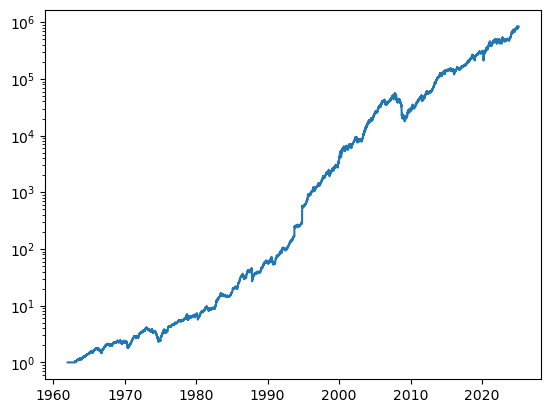

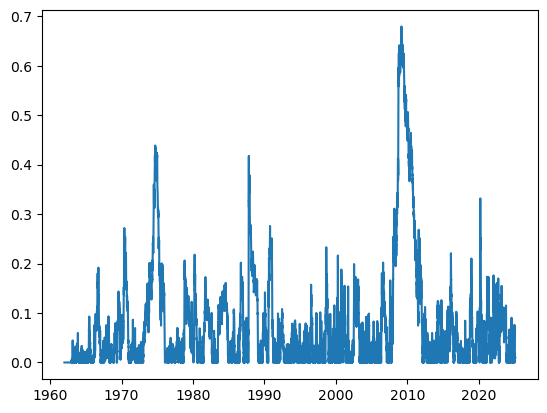

In [5]:
# Save the strategy weights to a CSV file for future analysis and reproducibility
print("Writing strategy weights into CSV file")
tiled_weights.to_csv("tiled_weights.csv")

# Read the strategy weights back from the CSV file to ensure they are correctly saved
print("Reading strategy weights from CSV file into pandas dataframe")
tiled_weights = pd.read_csv("tiled_weights.csv", index_col=0, parse_dates=True)

# Calculate the strategy returns by applying the strategy weights to the returns
strategy_returns = (tiled_weights * returns).sum(1)

# Save the strategy returns to a CSV file for performance evaluation
print("Writing strategy returns into CSV file")
strategy_returns.to_csv("strategy_returns.csv")

# Define a function to evaluate the performance of the strategy using various metrics
def evaluate_performance(returns, freq=252):
    # Calculate annual return, volatility, skewness, kurtosis, and other performance metrics
    annual_return = returns.mean() * freq
    annual_vol = returns.std() * np.sqrt(freq)
    skew = returns.skew()
    kurt = returns.kurt()
    info_ratio = annual_return / annual_vol
    downside_vol = returns[returns < 0].std() * np.sqrt(freq)
    sortino_ratio = annual_return / downside_vol
    cum_returns = (1 + returns).cumprod()
    cum_max = cum_returns.cummax()
    drawdowns = (cum_max - cum_returns) / cum_max
    max_drawdown = drawdowns.max()
    calmar_ratio = annual_return / max_drawdown
    
    # Print the performance metrics to provide a comprehensive evaluation of the strategy
    print()
    print(f"annual_return: {annual_return:.1%}")
    print(f"annual_vol: {annual_vol:.1%}")
    print(f"skew: {skew:.1f}")
    print(f"kurt: {kurt:.1f}")
    print(f"downside_vol: {downside_vol:.1%}")
    print(f"info_ratio: {info_ratio:.1f}")
    print(f"sortino_ratio: {sortino_ratio:.1f}")
    print(f"max_drawdown: {max_drawdown:.1%}")
    print(f"calmar_ratio: {calmar_ratio:.1f}")
    
    # Plot the cumulative returns to visualize the strategy's performance over time
    plt.plot(cum_returns, label="cum_returns")
    plt.yscale("log")
    plt.show()
    
    # Plot the drawdowns to understand the strategy's risk and resilience
    plt.plot(drawdowns, label="drawdowns")
    plt.show()

# Read the strategy returns back from the CSV file for performance evaluation
print("Reading strategy returns from CSV file into pandas dataframe")
strategy_returns = pd.read_csv(
    "strategy_returns.csv",
    index_col=0,
    parse_dates=True
    ).iloc[:, 0]

# Print the type of the strategy returns to confirm the data format
print(type(strategy_returns))

# Evaluate the performance of the strategy to understand its effectiveness
print("Evaluating strategy performance")
evaluate_performance(strategy_returns)

## Survivorship Bias in the Strategy

This trading strategy is subject to a significant bias known as **survivorship bias**. Survivorship bias occurs when a strategy or analysis only considers entities that have "survived" to the present day, ignoring those that have failed or been removed from the dataset over time.

### Why Survivorship Bias Matters

- **Current S&P 500 Composition**: The strategy uses the current list of S&P 500 companies, which includes only those companies that are part of the index as of today. This approach does not account for companies that were previously in the S&P 500 but have since been delisted due to bankruptcy, mergers, or other reasons.

- **Historical Accuracy**: By not including past members of the S&P 500, the strategy may overestimate historical performance. Companies that fail are often removed from the index, and their poor performance is not reflected in the analysis, leading to an optimistic view of past returns.

- **Risk Underestimation**: Survivorship bias can lead to an underestimation of risk. The strategy may appear less risky than it actually is because it does not account for the potential failure of companies that were once part of the index.

### Mitigating Survivorship Bias

To mitigate survivorship bias, one could use historical data that includes all companies that were part of the S&P 500 at each point in time, rather than just the current members. This approach would provide a more accurate representation of historical performance and risk.